# Exercise 2
Welcome to the second exercise, where we will visualize the unemployment rate in Switzerland (based on various definitions) on a map using colors and stuff. Enjoy your journey !

## 1) Data processing

In this part, we'll load the necessary data and prepare it for the visualization in part two

In [163]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt

In [17]:
swiss_data_file = "data/unemployment_rate_swiss.csv"

The required data can be acquired in the following was:
- go to the [amstat](https://www.amstat.ch/v2/index.jsp) website
- click on *Détails* link top right
- click *2 Chômeurs et demandeurs d'emplois*
- click *2.1 Taux de chômage*
- choose the following options: *Mois sous revue* (most recent month available, September 2017 at the time of doing this exercise), and for the indicators choose *Taux de chômage*, *Chômeurs inscrits*, *Demandeurs d'emplois* and *Demandeurs d'emplois non-chômeurs*. Don't forget to include the *Canton* as a geographical attribute !
- execute the report, which you can then export as CSV

A first manual step of cleaning was done using notepad++, which included removing useless headers and duplicate commas in some places

We load the CSV file as a dataframe. We have to specify the encoding because, by default, pandas will try to read using *utf-8* while the data is encoded using *utf-16*

In [18]:
swiss_data = pd.read_csv(swiss_data_file, encoding="utf-16")
swiss_data.head()

,Canton,Taux de chômage,Chômeurs inscrits,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs,Taux de chômage.1,Chômeurs inscrits.1,Demandeurs d'emploi.1,Demandeurs d'emploi non chômeurs.1
0,Zurich,3.3,27'225,34'156,6'931,3.3,27'225,34'156,6'931
1,Berne,2.4,13'658,18'385,4'727,2.4,13'658,18'385,4'727
2,Lucerne,1.7,3'885,6'756,2'871,1.7,3'885,6'756,2'871
3,Uri,0.6,112,257,145,0.6,112,257,145
4,Schwyz,1.7,1'455,2'229,774,1.7,1'455,2'229,774


The last columns (beginning from index 5) are duplicates of the first ones. They correspond to the total (over the months I assume) but as we're only considering one month, they're the same as the first ones. Let's drop them

In [19]:
#swiss_data.drop(swiss_data.columns[5:],axis=1,inplace=True)
swiss_data = swiss_data.T.drop_duplicates().T
swiss_data.head()

,Canton,Taux de chômage,Chômeurs inscrits,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs
0,Zurich,3.3,27'225,34'156,6'931
1,Berne,2.4,13'658,18'385,4'727
2,Lucerne,1.7,3'885,6'756,2'871
3,Uri,0.6,112,257,145
4,Schwyz,1.7,1'455,2'229,774


For everyone to be able to understand our homework with ease, let's rename the columns in english !

In [20]:
swiss_data_columns_dict = {"Canton":"canton","Taux de chômage":"unemployment_rate","Chômeurs inscrits":"unemployed","Demandeurs d'emploi":"job_seekers","Demandeurs d'emploi non chômeurs":"job_seekers_employed"}

In [21]:
swiss_data = swiss_data.rename(columns=swiss_data_columns_dict)
swiss_data.head()

,canton,unemployment_rate,unemployed,job_seekers,job_seekers_employed
0,Zurich,3.3,27'225,34'156,6'931
1,Berne,2.4,13'658,18'385,4'727
2,Lucerne,1.7,3'885,6'756,2'871
3,Uri,0.6,112,257,145
4,Schwyz,1.7,1'455,2'229,774


Now, we'll take care of column types. All columns (but the first) should have a numeric type. Let's have a look at the current types

In [22]:
swiss_data.dtypes

canton                  object
unemployment_rate       object
unemployed              object
job_seekers             object
job_seekers_employed    object
dtype: object

We will convert the "unemployment_rate" column to a float type and the remaining ones (but "Canton") to integer type. But for the latter group, we'll first have to remove the apostrophe character (') in the numbers. 

In [23]:
swiss_data.replace(regex=True, to_replace=r"'", value=r"", inplace=True)
swiss_data.head()

,canton,unemployment_rate,unemployed,job_seekers,job_seekers_employed
0,Zurich,3.3,27225,34156,6931
1,Berne,2.4,13658,18385,4727
2,Lucerne,1.7,3885,6756,2871
3,Uri,0.6,112,257,145
4,Schwyz,1.7,1455,2229,774


Perfect ! We can now convert the column to numeric types

In [24]:
# We get all the column names we defined before in the dictionary.
# The current columns are the values of the dictionary
numeric_columns = list(swiss_data_columns_dict.values())
numeric_columns.remove("canton")

swiss_data[numeric_columns] = swiss_data[numeric_columns].apply(pd.to_numeric)
swiss_data.dtypes

canton                   object
unemployment_rate       float64
unemployed                int64
job_seekers               int64
job_seekers_employed      int64
dtype: object

Just the desired types ! One last thing we can do is to remove the redundant column "job_seekers". This column contains the number of all job_seekers, whether they are employed or not. And as you can see and expect, it's the sum of *unemployed* and *job_seekers_employed*. But let's check this formallly

In [25]:
(swiss_data.unemployed + swiss_data.job_seekers_employed == swiss_data.job_seekers).all()

True

As expected. Let's drop the column:

In [26]:
swiss_data.drop(labels="job_seekers",axis=1,inplace=True)
swiss_data.head()

,canton,unemployment_rate,unemployed,job_seekers_employed
0,Zurich,3.3,27225,6931
1,Berne,2.4,13658,4727
2,Lucerne,1.7,3885,2871
3,Uri,0.6,112,145
4,Schwyz,1.7,1455,774


## 2) Visualizing the data

Before everything, something has to be precised. In the homework's readme, we can find the following affirmation:

> The Swiss Confederation defines the rates you have just plotted as **the number of people looking for a job divided by the size of the active population* (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

> Copy the map you have just created, but **this time don't count in your statistics people who already have a job** and are looking for a new one.

According to this, the unemployment rate we collected corresponds to the *unemployed* people and the *job_seekers_employed* summed up. But according to the [amstat](https://www.amstat.ch/v2/faq.jsp?lang=fr) website:

> Figurent dans la statistique des chômeurs toutes les personnes qui sont inscrites à un office régional de placement, **sont sans emploi** et immédiatement (c'est-à-dire dans un délai donné) disponibles pour placement. Peu importe qu'elles touchent, ou non, une indemnité de chômage.

Which means that the unemployment rate we collected only accounts for the *unemployed* people

### Exploration

We will start by loading the topojson file for the overlay

In [27]:
import json

In [28]:
cantons_geo_path = "topojson/ch-cantons.topojson.json"
topojson_swiss = json.load(open(cantons_geo_path,encoding="utf-8"))

Now let's try to visualize the overlay on the swiss map

In [29]:
swiss_map = folium.Map(location=[46.8, 8.4], tiles='cartodbpositron', zoom_start=7)
folium.TopoJson(open(cantons_geo_path),"objects.cantons").add_to(swiss_map)
swiss_map

Now let's try to display the visualization of interest: the Choropleth map showing the unemployment rate at the Swiss level

In [30]:
results_map = folium.Map(location=[46.8, 8.4], tiles='cartodbpositron', zoom_start=8)
results_map.choropleth(geo_data=topojson_swiss, topojson="objects.cantons", data=swiss_data,
             columns=['canton', 'unemployment_rate'],
             key_on='feature.properties.name',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployment (only people without a current job) (%)')
results_map

It appears there is no data for most cantons ! Our intuition tells us there's a matching problem between the names in the topojson file and the dataframe column *canton*. An exploration of the topojson file confirms this intuition: the names in the topojson are either in another language (Ticcino) and/or contain multiple alternatives (Valais/Wallis).

In [31]:
cantons_topojson = [x["properties"]["name"] for x in topojson_swiss['objects']['cantons']['geometries']]
cantons_topojson

['Zürich',
 'Bern/Berne',
 'Luzern',
 'Uri',
 'Schwyz',
 'Obwalden',
 'Nidwalden',
 'Glarus',
 'Zug',
 'Fribourg',
 'Solothurn',
 'Basel-Stadt',
 'Basel-Landschaft',
 'Schaffhausen',
 'Appenzell Ausserrhoden',
 'Appenzell Innerrhoden',
 'St. Gallen',
 'Graubünden/Grigioni',
 'Aargau',
 'Thurgau',
 'Ticino',
 'Vaud',
 'Valais/Wallis',
 'Neuchâtel',
 'Genève',
 'Jura']

### Matching

To solve the aformentioned problem, we'll proceed as follows: we'll use *difflib* to find the best match for each canton in the dataframe inside the list of cantons from the topojson 

In [32]:
from difflib import get_close_matches

In [33]:
def get_canton_adjusted_name(canton):
    """
    Returns the best match for the provided canton name, looking in the list of canton names extracted from the topojson file.
    If no match is found, returns None
    """
    similar_names = get_close_matches(canton, cantons_topojson, 1)
    if len(similar_names) > 0:
        return similar_names[0]
    else:
        return None

Let's have a first attempt at building the matching dictionary, and check the failing matches:

In [34]:
cantons_pandas = swiss_data['canton'].tolist()
# The key is the name of the canton inside pandas, the value is the name in the topojson
matching_cantons_tmp = dict((x, get_canton_adjusted_name(x)) for x in cantons_pandas)

# Let's check if some matches failed
[canton for canton,match in matching_cantons_tmp.items() if match == None]

['Bâle-Ville',
 'Bâle-Campagne',
 'Appenzell Rhodes-Extérieures',
 'Grisons',
 'Argovie',
 'Tessin',
 'Total']

We can see that some cantons couldn't be matched automatically. Because there are only a few of them, we'll add the matchings manually (if the dataset had been much bigger, we would certainly had needed another way to perform the matching, like a translation dictionary). We'll also remove the *Total*, which is present because it was a row in the original dataframe

In [35]:
additional_matches_cantons = {
    "Appenzell Rhodes-Extérieures" : "Appenzell Ausserrhoden",
    "Argovie": "Aargau",
    "Bâle-Campagne": "Basel-Landschaft",
    "Bâle-Ville": "Basel-Stadt",
    "Grisons": "Graubünden/Grigioni",
    "Tessin" : "Ticino", 
}

matching_cantons = {**matching_cantons_tmp, **additional_matches_cantons}
del matching_cantons["Total"]
matching_cantons

{'Appenzell Rhodes-Extérieures': 'Appenzell Ausserrhoden',
 'Appenzell Rhodes-Intérieures': 'Appenzell Innerrhoden',
 'Argovie': 'Aargau',
 'Berne': 'Bern/Berne',
 'Bâle-Campagne': 'Basel-Landschaft',
 'Bâle-Ville': 'Basel-Stadt',
 'Fribourg': 'Fribourg',
 'Genève': 'Genève',
 'Glaris': 'Glarus',
 'Grisons': 'Graubünden/Grigioni',
 'Jura': 'Jura',
 'Lucerne': 'Luzern',
 'Neuchâtel': 'Neuchâtel',
 'Nidwald': 'Nidwalden',
 'Obwald': 'Obwalden',
 'Schaffhouse': 'Schaffhausen',
 'Schwyz': 'Schwyz',
 'Soleure': 'Solothurn',
 'St-Gall': 'St. Gallen',
 'Tessin': 'Ticino',
 'Thurgovie': 'Thurgau',
 'Uri': 'Uri',
 'Valais': 'Valais/Wallis',
 'Vaud': 'Vaud',
 'Zoug': 'Zug',
 'Zurich': 'Zürich'}

Awesome, it seems that **all cantons have been matched** ! Let's just check the number of matches in the dictionary:

In [36]:
len(matching_cantons)

26

Yay ! Those are the 26 cantons.
Now we'll use the computed dictionary to rename the columns in the dataframe.

In [37]:
swiss_data_viz = swiss_data.copy()
swiss_data_viz.canton.replace(matching_cantons, inplace=True)
swiss_data_viz.head()

,canton,unemployment_rate,unemployed,job_seekers_employed
0,Zürich,3.3,27225,6931
1,Bern/Berne,2.4,13658,4727
2,Luzern,1.7,3885,2871
3,Uri,0.6,112,145
4,Schwyz,1.7,1455,774


### Visualization

#### Unemployment rate: people without a job

In [38]:
results_map_unemployment = folium.Map(location=[46.8, 8.4], tiles='cartodbpositron', zoom_start=7)
results_map_unemployment.choropleth(geo_data=topojson_swiss, topojson="objects.cantons", data=swiss_data_viz,
             columns=['canton', 'unemployment_rate'],
             key_on='feature.properties.name',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployment (only people without a current job) (%)')
results_map_unemployment

Now we have data for the whole country ! Enjoy :)
We see the unemployment rate is higher in the french part of Switzerland :( Geneva and Neuchatel are among the worst.

We could compare this with the unemployment rate taking into account the people having a job and looking for a new one

#### Unemployment rate: people with/out a job

Let's first infer the active population number using the unemployment rate and the number of unemployed people. For this, we'll use the very advanced *règle de trois* technique:

In [39]:
# swiss_data_viz["unemployment_rate_with_employed"] = \\
swiss_data_viz["active_pop"] = 100. * swiss_data_viz.unemployed / swiss_data_viz.unemployment_rate
swiss_data_viz.active_pop = swiss_data_viz.active_pop.round().astype("int")
swiss_data_viz.head()

,canton,unemployment_rate,unemployed,job_seekers_employed,active_pop
0,Zürich,3.3,27225,6931,825000
1,Bern/Berne,2.4,13658,4727,569083
2,Luzern,1.7,3885,2871,228529
3,Uri,0.6,112,145,18667
4,Schwyz,1.7,1455,774,85588


In [40]:
swiss_data_viz["unemployment_rate_with_employed"] = (swiss_data_viz.unemployed + swiss_data_viz.job_seekers_employed) / swiss_data_viz.active_pop * 100
swiss_data_viz.head()

,canton,unemployment_rate,unemployed,job_seekers_employed,active_pop,unemployment_rate_with_employed
0,Zürich,3.3,27225,6931,825000,4.140121
1,Bern/Berne,2.4,13658,4727,569083,3.230636
2,Luzern,1.7,3885,2871,228529,2.956299
3,Uri,0.6,112,145,18667,1.376761
4,Schwyz,1.7,1455,774,85588,2.604337


In [41]:
results_map_seeking_jobs = folium.Map(location=[46.8, 8.4], tiles='cartodbpositron', zoom_start=7)
results_map_seeking_jobs.choropleth(geo_data=topojson_swiss, topojson="objects.cantons", data=swiss_data_viz,
             columns=['canton', 'unemployment_rate_with_employed'],
             key_on='feature.properties.name',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of unemployment (only people without a current job) (%)')
results_map_seeking_jobs

The trends are very similar to the previous one

### Polishing
Don't worry, you won't have much to read from now. We'll just save the maps for you to be able to enjoy them with any web browser.

In [42]:
results_map_unemployment.save('Swiss_unemployment_rate_without_current_job.html')
results_map_seeking_jobs.save('Swiss_unemployment_rate.html')

# Thank you
We hope you enjoyed reading this exercise ! Still one left :)

# Exercise 3
And let's do the final exercise. First we will have to compare the unemployment rate of foreigners to the swiss one. Then we will try to measure the discrepancy between the two. And finally we will also look at the three age categories and compare them.

So, first let's go grab the data on amstat:
- go to the [amstat](https://www.amstat.ch/v2/index.jsp) website
- click on *Détails* link top right
- click *2 Chômeurs et demandeurs d'emplois*
- click *2.1 Taux de chômage*
- choose the following options: *Mois sous revue* (most recent month available, September 2017 at the time of doing this exercise), and for the indicators choose *Taux de chômage*, *Chômeurs inscrits*, *Demandeurs d'emplois* and *Demandeurs d'emplois non-chômeurs*. Don't forget to include the *Canton* as a geographical attribute ! And, of course, you have to add the "Nationalité" parameter
- execute the report, which you can then export as CSV

Here, we also have to clean the file a little bit with a text edit program in order for pandas to parse it more easily.

In [43]:
nationality_data_file = r'data/taux_chomage_nationalite_non_chomeurs.csv'
nationality_data = pd.read_csv(nationality_data_file, encoding="utf-16")
nationality_data.head()

,Canton,Nationalité,Mesures,Taux de chômage,Chômeurs inscrits,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs,Taux de chômage.1,Chômeurs inscrits.1,Demandeurs d'emploi.1,Demandeurs d'emploi non chômeurs.1
0,Zurich,Etrangers,NaN,5.3,12'111,15'384,3'273,5.3,12'111,15'384,3'273
1,Zurich,Suisses,NaN,2.5,15'114,18'772,3'658,2.5,15'114,18'772,3'658
2,Berne,Etrangers,NaN,5.5,4'900,6'859,1'959,5.5,4'900,6'859,1'959
3,Berne,Suisses,NaN,1.8,8'758,11'526,2'768,1.8,8'758,11'526,2'768
4,Lucerne,Etrangers,NaN,3.9,1'593,2'902,1'309,3.9,1'593,2'902,1'309


As in the last exercise, the last columns correspond to totals over the months but since we only have the data for September 2017 we can freely drop it:

In [44]:
nationality_data = nationality_data.T.drop_duplicates().T
nationality_data = nationality_data.drop('Mesures', axis=1)
nationality_data.head()

,Canton,Nationalité,Taux de chômage,Chômeurs inscrits,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs
0,Zurich,Etrangers,5.3,12'111,15'384,3'273
1,Zurich,Suisses,2.5,15'114,18'772,3'658
2,Berne,Etrangers,5.5,4'900,6'859,1'959
3,Berne,Suisses,1.8,8'758,11'526,2'768
4,Lucerne,Etrangers,3.9,1'593,2'902,1'309


We rename everything to english:

In [45]:
nationality_data_columns_dict = {"Canton":"canton","Nationalité":"nationality", "Taux de chômage":"unemployment_rate","Chômeurs inscrits":"unemployed","Demandeurs d'emploi":"job_seekers","Demandeurs d'emploi non chômeurs":"job_seekers_employed"}
nationality_data = nationality_data.rename(columns=nationality_data_columns_dict)
nationality_data.head()

,canton,nationality,unemployment_rate,unemployed,job_seekers,job_seekers_employed
0,Zurich,Etrangers,5.3,12'111,15'384,3'273
1,Zurich,Suisses,2.5,15'114,18'772,3'658
2,Berne,Etrangers,5.5,4'900,6'859,1'959
3,Berne,Suisses,1.8,8'758,11'526,2'768
4,Lucerne,Etrangers,3.9,1'593,2'902,1'309


Again, we have the problem with the apostrophe so we will have to convert our values into numeric ones:

In [46]:
nationality_data.replace(regex=True, to_replace=r"'", value=r"", inplace=True)
numeric_columns = list(nationality_data_columns_dict.values())
numeric_columns.remove("canton")
numeric_columns.remove("nationality")

nationality_data[numeric_columns] = nationality_data[numeric_columns].apply(pd.to_numeric)
nationality_data.dtypes

canton                   object
nationality              object
unemployment_rate       float64
unemployed                int64
job_seekers               int64
job_seekers_employed      int64
dtype: object

Again, we simply check that the job seekers is the sum of the unemployed and the employed job seekers:

In [47]:
(nationality_data.unemployed + nationality_data.job_seekers_employed == nationality_data.job_seekers).all()

True

So we simply drop the job_seekers column:

In [48]:
nationality_data.drop(labels="job_seekers",axis=1,inplace=True)
nationality_data.head()

,canton,nationality,unemployment_rate,unemployed,job_seekers_employed
0,Zurich,Etrangers,5.3,12111,3273
1,Zurich,Suisses,2.5,15114,3658
2,Berne,Etrangers,5.5,4900,1959
3,Berne,Suisses,1.8,8758,2768
4,Lucerne,Etrangers,3.9,1593,1309


Actually, nothing in the exercise description specifies that we should include the job seekers who are already employed so we will simply drop the column. But if you want to include them then it is easy: you do the same thing we did in exercise 2: you divide the unemployed column by the unemployment_rate column in order to obtain the active population and then you sum up the two columns and you divide the sum by the active population to obtain the new rate. But let's simply keep the unemployment rate:

In [49]:
nationality_data.drop(labels=["unemployed", "job_seekers_employed"], axis=1, inplace=True)
nationality_data.head()

,canton,nationality,unemployment_rate
0,Zurich,Etrangers,5.3
1,Zurich,Suisses,2.5
2,Berne,Etrangers,5.5
3,Berne,Suisses,1.8
4,Lucerne,Etrangers,3.9


Same thing as before: if we want the amstat canton names to be compatible with the TopoJSON ones then we have to do the matching:

In [55]:
nationality_data_viz = nationality_data.copy()
nationality_data_viz.canton.replace(matching_cantons, inplace=True)
nationality_data_viz.head()

,canton,nationality,unemployment_rate
0,Zürich,Etrangers,5.3
1,Zürich,Suisses,2.5
2,Bern/Berne,Etrangers,5.5
3,Bern/Berne,Suisses,1.8
4,Luzern,Etrangers,3.9


Now we divide the data into two frames: one for swiss and one for foreign people:

In [56]:
nationality_data_viz.set_index('nationality', inplace=True)
nationality_data_viz_swiss = nationality_data_viz.loc["Suisses"]
nationality_data_viz_foreign = nationality_data_viz.loc["Etrangers"]

And we show the map for swiss people:

In [67]:
def viz_unemployment(frame, legend_name):
    results_map_unemployment = folium.Map(location=[46.8, 8.4], zoom_start=8)
    results_map_unemployment.choropleth(geo_data=topojson_swiss, topojson="objects.cantons", data=frame,
             columns=['canton', 'unemployment_rate'],
             key_on='feature.properties.name',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name=legend_name)
    return results_map_unemployment
viz_unemployment(nationality_data_viz_swiss, 'Percentage of unemployment (Swiss people) (%)')

We can observe that the trends are similar to the global unemployment from question 2 (except maybe if we take Ticino and Zürich cantons where the swiss unemployment is lower).
Now let's take a look at the unemployment for foreign people:

In [68]:
viz_unemployment(nationality_data_viz_foreign, 'Percentage of unemployment (Foreign people) (%)')

Globally, the unemployment rate is higher for foreign people than for swiss (it is pretty obvious since the scale goes from 2 to 9 while it was from 0.4 to 4.8 for swiss). The cantons where foreign unemployment is the highest are more the western cantons but this time we can also include some non french-speaking cantons like Bern and Argau. We also see that Jura has the highest foreign unemployment rate.

## Measuring discrepancy
Now we want to show the discrepancy between the two on a single map. We could find multiple ways of doing that. We will do it in two different ways: first we will show the difference (substraction) between foreign and swiss rates and then we will show the ratios (division).

In [79]:
def viz_discrepancy(dis_function, legend_name):
    discrepancy = nationality_data_viz_foreign.copy().reset_index()
    discrepancy['discrepancy'] = dis_function(discrepancy.reset_index()['unemployment_rate'], 
                                              nationality_data_viz_swiss.reset_index()['unemployment_rate'])
    results_map_unemployment = folium.Map(location=[46.8, 8.4], zoom_start=8)
    results_map_unemployment.choropleth(geo_data=topojson_swiss, topojson="objects.cantons", data=discrepancy,
             columns=['canton', 'discrepancy'],
             key_on='feature.properties.name',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name=legend_name)
    return results_map_unemployment
viz_discrepancy(lambda x, y: x - y, "Discrepancy (substraction)")

And now the division:

In [80]:
viz_discrepancy(lambda x, y: x / y, "Discrepancy (division)")

So now let us comment a little bit on this. We see something very interesting: the division discrepancy seems to be completely different than the substraction discrepancy (the substraction discrepancy is the highest in western cantons but the division discrepancy is the highest in eastern cantons). This may seem strange but actually there is an explanation. Let's take two respective "representatives" of the two groups: Jura and Uri cantons:

In [95]:
def get_unemployment(nationality, canton):
    if nationality == "Suisses":
        frame = nationality_data_viz_swiss.copy()
    else:
        frame = nationality_data_viz_foreign.copy()
    return frame[frame["canton"] == canton].get_value(nationality, "unemployment_rate")
foreign_jura = get_unemployment("Etrangers", "Jura")
foreign_uri = get_unemployment("Etrangers", "Zug")
swiss_jura = get_unemployment("Suisses", "Jura")
swiss_uri = get_unemployment("Suisses", "Uri")
print("Jura canton: {} % foreign and {} % swiss unemployment rate".format(foreign_jura, swiss_jura))
print("Uri canton: {} % foreign and {} % swiss unemployment rate".format(foreign_uri, swiss_uri))

Jura canton: 9.0 % foreign and 3.6 % swiss unemployment rate
Uri canton: 3.9 % foreign and 0.4 % swiss unemployment rate


Here we see why we have the big difference between the two discrepancy measure. For Jura canton we have 5.4 % of substraction discrepancy but only a ratio of 2.5 . But with Uri canton we have less substraction discrepancy (3.5 %) but the ratio is much bigger (9.75). 

To put things simply, let's imagine a canton where the global unemployment rate is very good (let's say 0.9%) In this canton there is 0.05 % of swiss unemployment and 1% of foreign unemployment. Now the difference is only 0.95 % but the ratio discrepancy is 20 even of both numbers are really good ! So choosing which discrepancy we want to show simply depends on "what" we want to show with that map. In some applications it may be smarter to choose substraction discrepancy and in others ratio discrepancy may be a better choice.

## Age categories
Now let's plot the age categories:
So, first let's go grab the data on amstat:
- go to the [amstat](https://www.amstat.ch/v2/index.jsp) website
- click on *Détails* link top right
- click *2 Chômeurs et demandeurs d'emplois*
- click *2.1 Taux de chômage*
- choose the following options: *Mois sous revue* (most recent month available, September 2017 at the time of doing this exercise), and for the indicators choose *Taux de chômage*, *Chômeurs inscrits* (we don't bother with job seekers who are already employed). Don't forget to include the *Canton* as a geographical attribute ! And finally we take the "Classe d'âge, 15-24, 25-49, 50 ans et plus" indicator.
- execute the report, which you can then export as CSV

Again we have to do some cleaning in a text editor before using the file

In [104]:
age_class_file = r'data/taux_de_chomage_classes_age.csv'
age_class_data = pd.read_csv(age_class_file, encoding='utf-16')

In [105]:
age_class_data

,Canton,"Classes d'âge 15-24, 25-49, 50 ans et plus",age_class,Mesures,Taux de chômage,Chômeurs inscrits,Taux de chômage.1,Chômeurs inscrits.1
0,Zurich,1.0,15-24 ans,NaN,3.7,3'420,3.7,3'420
1,Zurich,2.0,25-49 ans,NaN,3.4,17'053,3.4,17'053
2,Zurich,3.0,50 ans et plus,NaN,2.9,6'752,2.9,6'752
3,Berne,1.0,15-24 ans,NaN,2.8,2'003,2.8,2'003
4,Berne,2.0,25-49 ans,NaN,2.5,7'773,2.5,7'773
5,Berne,3.0,50 ans et plus,NaN,2.2,3'882,2.2,3'882
6,Lucerne,1.0,15-24 ans,NaN,2.1,664,2.1,664
7,Lucerne,2.0,25-49 ans,NaN,1.7,2'159,1.7,2'159
8,Lucerne,3.0,50 ans et plus,NaN,1.6,1'062,1.6,1'062
9,Uri,1.0,15-24 ans,NaN,0.5,15,0.5,15


In [145]:
age_class_file = r'data/taux_de_chomage_classes_age.csv'
age_class_data = pd.read_csv(age_class_file, encoding='utf-16')

# We remove the duplicates columns (don't need the total since only one month)
age_class_data = age_class_data.T.drop_duplicates().T
age_class_data = age_class_data.drop(['Mesures', 'age_class_string'], axis=1)

# We rename the columns
age_class_data_columns_dict = {"Canton":"canton","Classes d'âge 15-24, 25-49, 50 ans et plus":"age_class", 
                               "Taux de chômage":"unemployment_rate","Chômeurs inscrits":"unemployed"}
age_class_data = age_class_data.rename(columns=age_class_data_columns_dict)

# We remove the "Total" row at the end
age_class_data = age_class_data.drop(age_class_data.tail(1).index)

# We rename the cantons (no need to do that since we won't use the TopoJSON file but we just want to be consistent)
age_class_data.canton.replace(matching_cantons, inplace=True)

# We convert the columns to numeric type
age_class_data.replace(regex=True, to_replace=r"'", value=r"", inplace=True)
numeric_columns = ["age_class", "unemployment_rate", "unemployed"]
age_class_data[numeric_columns] = age_class_data[numeric_columns].apply(pd.to_numeric)

age_class_data.head()

,canton,age_class,unemployment_rate,unemployed
0,Zürich,1.0,3.7,3420
1,Zürich,2.0,3.4,17053
2,Zürich,3.0,2.9,6752
3,Bern/Berne,1.0,2.8,2003
4,Bern/Berne,2.0,2.5,7773


In [146]:
age_class_data_index = age_class_data.set_index(["age_class"])

age_class_1 = age_class_data_index.loc[1]
age_class_2 = age_class_data_index.loc[2]
age_class_3 = age_class_data_index.loc[3]

In [150]:
canton_names = age_class_1.canton.tolist()
class_1_values = age_class_1.unemployment_rate.tolist()
class_2_values = age_class_2.unemployment_rate.tolist()
class_3_values = age_class_3.unemployment_rate.tolist()

Populating the interactive namespace from numpy and matplotlib


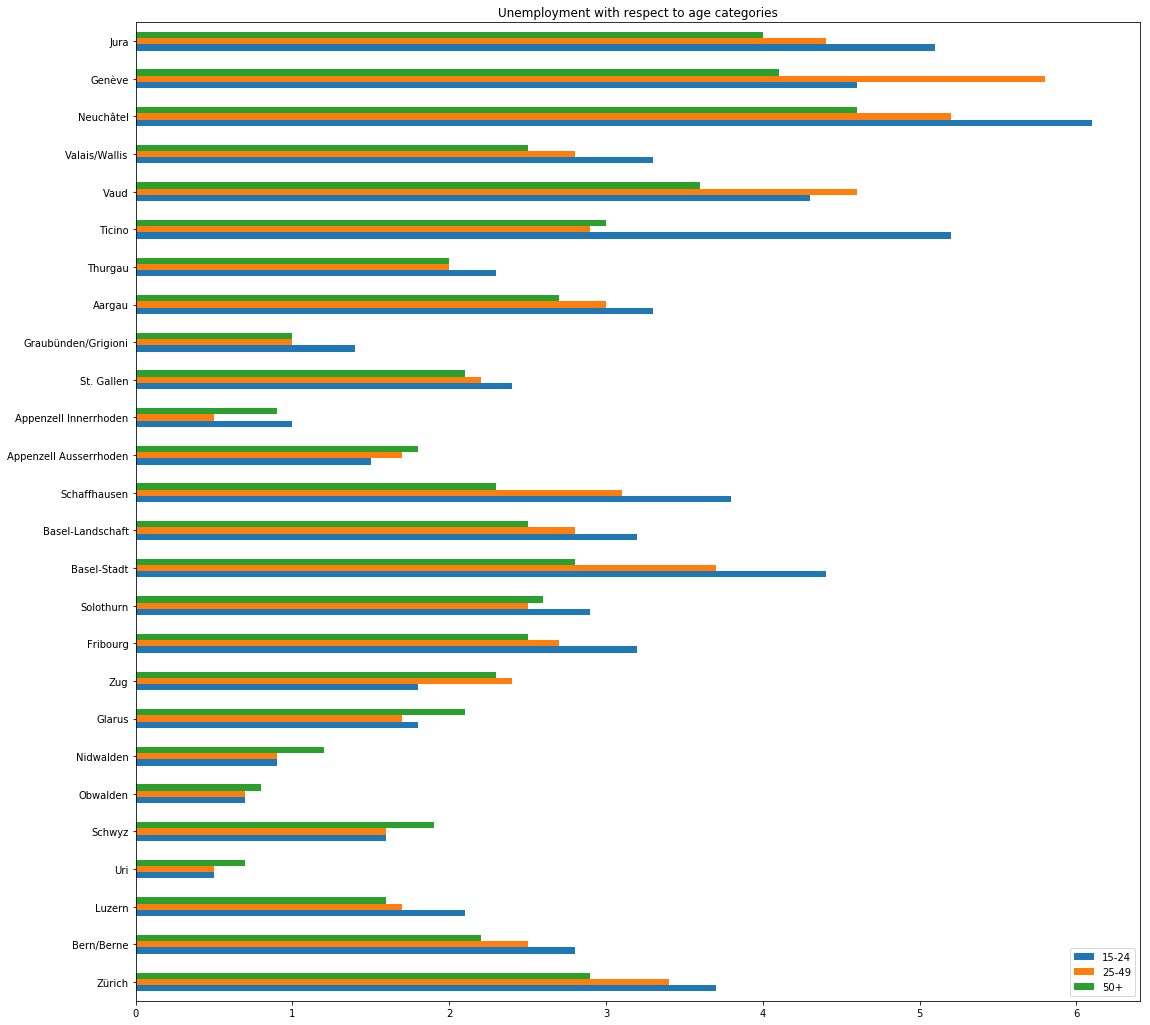

In [173]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 18)

df = pd.DataFrame(index=canton_names, data={'15-24' : class_1_values,'25-49' : class_2_values, '50+' : class_3_values})
ax = df.plot.barh();

ax.set_title("Unemployment with respect to age categories")
ax.legend(loc='lower right')

plt.show()

## Age classes and nationalities
Additionally, since we are not sure what the question is exactly, we want to have a plot showing six classes: the 3 age classes x the two nationalities. So we are doing it here just to be sure. One problem is that we cannot get the rates if we choose more than one attribute (we have two attributes: nationality and age class). We can only have the numbers:

In [180]:
file_age_nationality = r'data/nb_chomeurs_age_nationalite.csv'
data_age_nationality = pd.read_csv(file_age_nationality, encoding='utf-16')
data_age_nationality.drop(['Mesures', 'class_string'], axis=1, inplace=True)
data_age_nationality.rename(columns={'Canton': 'canton', 'Nationalité': 'nationality', 
                                     "Classes d'âge 15-24, 25-49, 50 ans et plus": 'age_class',
                                        'Chômeurs inscrits': 'nb_une'}, inplace=True)
data_age_nationality.replace(regex=True, to_replace=r"'", value=r"", inplace=True)

data_age_nationality.canton.replace(matching_cantons, inplace=True)

numeric_columns = ["nb_une"]
data_age_nationality[numeric_columns] = data_age_nationality[numeric_columns].apply(pd.to_numeric)

data_age_nationality.head()

,canton,nationality,age_class,nb_une
0,Zürich,Etrangers,1,1015
1,Zürich,Etrangers,2,8846
2,Zürich,Etrangers,3,2250
3,Zürich,Etrangers,Total,12111
4,Zürich,Suisses,1,2405


In [181]:
swiss_data_viz

,canton,unemployment_rate,unemployed,job_seekers_employed,active_pop,unemployment_rate_with_employed
0,Zürich,3.3,27225,6931,825000,4.140121
1,Bern/Berne,2.4,13658,4727,569083,3.230636
2,Luzern,1.7,3885,2871,228529,2.956299
3,Uri,0.6,112,145,18667,1.376761
4,Schwyz,1.7,1455,774,85588,2.604337
5,Obwalden,0.7,153,166,21857,1.459487
6,Nidwalden,1.0,248,188,24800,1.758065
7,Glarus,1.8,416,297,23111,3.085111
8,Zug,2.3,1543,1072,67087,3.897924
9,Fribourg,2.7,4466,3371,165407,4.738010
